<a href="https://colab.research.google.com/github/erengursu/Face_Mask_Detector/blob/main/Face_Mask_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Mask Detection**

In [ ]:
!pip list

In [ ]:
!pip freeze

**Mounting GDrive:**

In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


**Remove Folder with its subfolders:**

In [21]:
!rm -rf dataset/

**Creates compressed ZIP file from the folder:**

In [ ]:
!zip -r dataset_shuffled.zip dataset_shuffled/

**Indıcates how many file under the folder:**

In [ ]:
!ls /content/dataset_shuffled_v2/without_mask/ | wc -l

**Total size of the folders' subcontent:**

In [ ]:
!du -h /content/imagens/

In [ ]:
!ls -lsh /content/

In [ ]:
import os

cwd = os.getcwd()
mdl = os.path.sep.join([os.getcwd(), "drive", "MyDrive", "avatar.jpg"])
print(mdl)

## **Dataset**

In [10]:
!mkdir dataset

In [ ]:
!pip list

In [ ]:
!rm -rf imagens

**Uploading from the local:**

In [9]:
from google.colab import files
uploaded = files.upload()

**Extracting the .zip compressed file:**

In [ ]:
!unzip /content/drive/MyDrive/mask_dataset_images.zip

In [ ]:
!mv /content/with_mask_improper /content/dataset_shuffled_v2/

**Listing of the content of the folder:**

In [ ]:
!ls /content/dataset_shuffled/without_mask/

### Rename the files in directory

Below shell command code rename the files as numbers in incremental fashion in current directory. Be aware that one first needs to go to intended directory first.

In [ ]:
ls -1prt | grep -v "/$" | cat -n | while read n f; do mv -n "${f}" "$(printf "%04d" $n).${f#*.}"; done

### Shuffle from large dataset into small data set randomly

Shuffle and copy specific number of item of specific file type from one directory to another randomly.

Shell command to copy 2000 .jpg type file randomly from dirst indicated directory to second indicated directory.

In [ ]:
!find /content/dataset/with_mask/ -type f -name "*.jpg" -print0 | xargs -0 shuf -e -n2000 -z | xargs -0 cp -vt /content/dataset_shuffled/with_mask/

Python and numpy script to shuffle and copy specified type of file(.jpg) with specified numbers from one directory to another. In this script, labels are in same directory with data images as .txt files. Therefore, that part is unneccessary to shuffle and copy purpose, so be aware!

In [ ]:
import numpy as np
import os
import random

#set directories
directory = str('/content/dataset_shuffled/with_mask_improper')
target_directory = str('/content/dataset_shuffled_v2/with_mask_improper')
data_set_percent_size = float(0.07)

#print(os.listdir(directory))

# list all files in dir that are an image
files = [f for f in os.listdir(directory) if f.endswith('.jpg')]

#print(files)

# select a percent of the files randomly, or like we did give specific number 
random_files = random.sample(files, int(2000))
#random_files = random.sample(files, int(len(files)*data_set_percent_size))
#random_files = np.random.choice(files, int(len(files)*data_set_percent_size))

#print(random_files)

# move the randomly selected images by renaming directory 

for random_file_name in random_files:      
    #print(directory+'/'+random_file_name)
    #print(target_directory+'/'+random_file_name)
    os.rename(directory+'/'+random_file_name, target_directory+'/'+random_file_name)
    continue

# move the relevant labels for the randomly selected images

#for image_labels in random_files:
    # strip extension and add .txt to find corellating label file then rename directory. 
    #os.rename(directory+'/'+(os.path.splitext(image_labels)[0]+'.txt'), target_directory+'/'+(os.path.splitext(image_labels)[0]+'.txt'))

    #continue

## **Training**

Train from the shell command prompt.

In [ ]:
!python train_mask_detector_3class.py --dataset dataset/

### Face Detector Trainer Script

This code is suitable to be used inline command as script.

In [ ]:
# USAGE
#Original python script. Intended to be used in line.
# python train_mask_detector.py --dataset dataset

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--dataset", required=True,
	help="path to dataset")
ap.add_argument("-p", "--plot", type=str, default="plot.png",
	help="path to output loss/accuracy plot")
ap.add_argument("-m", "--model", type=str,
	default="face_mask_detector.model",
	help="path to output face mask detector model")
args = vars(ap.parse_args())

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(args["model"], save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])

### Face Mask Trainer Colab Script

This script is suitable to be run on Colab. One must careful about default locations fiven for face_detector scripts. For our case:

'/content/dataset'

#### Working Colab script for 2 classes : with_mask and without_mask

In [ ]:
# USAGE
# Suitable for Colab usage
# One must be careful about dataset destination
# USAGE FROM TERMINAL
# python train_mask_detector.py --dataset "dataset_folder_name"
# Note that script must be in the same directory with your dataset folder.

### Changelog ####
# Confusion_matrix calculation added to last line
# Dataset: "content/imagens" with 3 class
# Batch_size: 32
# EPOCH : 20
# Dense.relu : 128

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow is a binary categorical variable with values 0 and 1 w.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images('/content/dataset_shuffled_v2/'))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
# Dense softmax layer is made to be 3 to accomodate 3 classes
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('/content/face_mask_detector.model', save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('/content/plot.png')

#### Colab script for 3 classes : with_mask, with_mask_improper and without_mask

In [ ]:
# USAGE
# Suitable for Colab usage
# One must be careful about dataset destination
# USAGE FROM TERMINAL
# python train_mask_detector.py --dataset "dataset_folder_name"
# Note that script must be in the same directory with your dataset folder.

### Changelog ####
# Confusion_matrix calculation added to last line
# Dataset: "content/imagens" with 3 class
# Batch_size: 32
# EPOCH : 20
# Dense.relu : 128 (Might be 256 with whole 'imagens' dataset)

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images('/content/dataset_shuffled_v2/'))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
with_mask_improper
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),with_mask_improper
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('/content/face_mask_detector.model', save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('/content/plot.png')

#### Experimental Colab script for 3 classes : with_mask, with_mask_improper and without_mask

In [ ]:
# USAGE
# Suitable for Colab usage
# One must be careful about dataset destination


# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images('/content/dataset_shuffled_v2/'))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)


[INFO] loading images...


In [ ]:
labels

In [ ]:
# perform one-hot encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
labels

[INFO] compiling model...
[INFO] training head...
Epoch 1/20
150/150 [==============================] - 83s 338ms/step - loss: 0.4524 - accuracy: 0.7038 - val_loss: 0.1197 - val_accuracy: 0.9725
Epoch 2/20
150/150 [==============================] - 49s 327ms/step - loss: 0.1413 - accuracy: 0.9466 - val_loss: 0.0680 - val_accuracy: 0.9775
Epoch 3/20
150/150 [==============================] - 49s 326ms/step - loss: 0.0893 - accuracy: 0.9688 - val_loss: 0.0494 - val_accuracy: 0.9833
Epoch 4/20
150/150 [==============================] - 49s 329ms/step - loss: 0.0709 - accuracy: 0.9709 - val_loss: 0.0392 - val_accuracy: 0.9883
Epoch 5/20
150/150 [==============================] - 49s 329ms/step - loss: 0.0656 - accuracy: 0.9716 - val_loss: 0.0339 - val_accuracy: 0.9867
Epoch 6/20
150/150 [==============================] - 49s 328ms/step - loss: 0.0593 - accuracy: 0.9763 - val_loss: 0.0300 - val_accuracy: 0.9900
Epoch 7/20
150/150 [==============================] - 49s 327ms/step - loss: 0.0

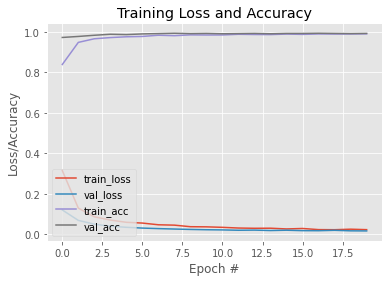

In [ ]:

# partition the data into trainin)g and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=le.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save('/content/face_mask_detector.model', save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")with_mask_improper
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('/content/plot.png')

### Another approach from internet

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# Params
IMAGE_WIDTH = 300
IMAGE_HEIGHT = 300
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 1
IMG_DIR = '/content/dataset/'
BATCH_SIZE = 32
NUM_CLASSES = 4
# Model
base_model = MobileNetV2(
    weights= None,
    include_top=False,
    input_shape= (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
opt = Adam(lr=0.000125)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
callbacks_list = [ModelCheckpoint('../weights/service_weights.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'),
    EarlyStopping(monitor='val_accuracy', patience=5),
    ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)]

In [ ]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 8
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)    return imgtrain_datagen = ImageDataGenerator(
    brightness_range=[0.2, 1.6],
    rescale=1. / 255,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function=add_noise,
)train_generator = train_datagen.flow_from_dataframe(
    train_df,
    IMG_DIR,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode = 'grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE
)
validation_datagen = ImageDataGenerator(rescale=1./255)validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    IMG_DIR,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode = 'grayscale',
    class_mode='categorical',
    shuffle=False,
    batch_size=BATCH_SIZE
)

In [ ]:
epochs=50 if FAST_RUN else 50history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks_list
)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(validate_df.category, validate_df.pred))

## **Test**

In [ ]:
!unzip file.zip

In [ ]:
!rm file.zip

In [ ]:
!rm detect_mask_video_v3.py

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!python detect_mask_video_v3.py

In [ ]:
!python detect_mask_image_v6.py --image test_imageset/without_mask/nm_02.jpg

>### ***Make Directory Where All Our Captured Videos are stored***











In [ ]:
!git clone https://github.com/opencv/opencv.git
!mkdir Video



>### ***Import Javascript Code to Open Webcam***



In [ ]:
!pip install ffmpeg-python


from IPython.display import HTML, Javascript, display
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
import ffmpeg

video_file_test = '/content/Video/osy_test.mp4' 
  

VIDEO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var my_btn_txt = document.createTextNode("Press to start recording");

my_btn.appendChild(my_btn_txt);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, videoStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  videoStream = stream;
  var options = {  
    mimeType : 'video/webm;codecs=vp9'  
  };            
  recorder = new MediaRecorder(stream, options);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('video');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);
    
    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({video: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      videoStream.getVideoTracks()[0].stop();
      recordButton.innerText = "Saving the recording... Please wait!"
  }
}

function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def start_webcam():
  js = Javascript('''
    async function startWebcam() {
      const div = document.createElement('div');
      
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      
      return;
    
    }
    ''')
  
  display(js)
  data = eval_js('startWebcam()')
  
    
start_webcam()

def get_video():
  display(HTML(VIDEO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  return binary

>### ***Open Captured Video***

In [ ]:
videofile = get_video()
with open(video_file_test, 'wb') as f:
  f.write(videofile)

>### ***Some Example Code using Captured Video Stream***

In [ ]:
import cv2  
from google.colab.patches import cv2_imshow

face_cascade = cv2.CascadeClassifier('/content/opencv/data/haarcascades/haarcascade_frontalface_default.xml') 
eye_cascade = cv2.CascadeClassifier('/content/opencv/data/haarcascades/haarcascade_eye.xml')  

cap = cv2.VideoCapture(video_file_test) 
  
count = 1
while cap.isOpened() & count<30:
  
    ret, img = cap.read()  
  
   # gray = cv2.cvtColor(img, cv2.COLOR_BGR2BGR) 
  
    # Detects faces of different sizes in the input image 
    faces = face_cascade.detectMultiScale(img, 1.3, 5) 
  
    for (x,y,w,h) in faces: 
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,255,0),2)  
       # roi_gray = gray[y:y+h, x:x+w] 
        roi_color = img[y:y+h, x:x+w] 
  
        eyes = eye_cascade.detectMultiScale(roi_color)  
  
        for (ex,ey,ew,eh) in eyes: 
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,127,255),2) 

    cv2_imshow(img) 
  
    k = cv2.waitKey(30) & 0xff
    if k == 27: 
        break
  
cap.release() 
cv2.destroyAllWindows()  

### **Detect Mask From Image**

In [ ]:

#version == 6 >> Inline detection result return added << 

# USAGE
# python detect_mask_image.py --image test_imageset/with_mask/m_01.jpg

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
#from google.colab.patches import cv2_imshow
#from skimage import io
#from PIL import Image
#import matplotlib.pylab as plt
import os

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to input image")
ap.add_argument("-f", "--face", type=str,
	default="face_detector",
	help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model(args["model"])

# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread(args["image"])
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > args["confidence"]:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]
		
		# this is the section where I put the inline verbose. 'Twas last resort on GColab. Comment it out when running the script locally.
		detection = "Mask" if mask > withoutMask else "No Mask"
		confidence_percentage = "{}: {:.2f}%".format(detection, max(mask, withoutMask) * 100)
		print(confidence_percentage)

		# determine the class label and color we'll use to draw
		# the bounding box and text
		# COMMENT IN WHEN DEPLOYING LOCALLY
		# label = "Mask" if mask > withoutMask else "No Mask"
		# color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		# label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		# cv2.putText(image, label, (startX, startY - 10),
			#cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		#cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
#cv2_imshow(image)
#cv2.waitKey(0)

In [ ]:

# Version == 3 >> Intended to be used on Colab or Jupyter. cv2.imshow is replaced with cv2_imshow which doesn't need x server to operate <<

# USAGE
# python detect_mask_image.py --image test_imageset/with_mask/m_01.jpg

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
#from IPython.display import Image
import numpy as np
import argparse
import cv2
import os

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", required=True,
	help="path to input image")
ap.add_argument("-f", "--face", type=str,
	default="face_detector",
	help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join(["/content/face_detector", "deploy.prototxt"])
weightsPath = os.path.sep.join(["/content/face_detector",
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model('/content/mask_detector.model')

# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread('/content/test_imageset/with_mask/m_01.jpg')
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > args["confidence"]:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
cv2_imshow(image)

In [ ]:

# Version == 1 >> Original Code. Can be used locally with x server system. <<

# USAGE
# python detect_mask_image.py --image test_imageset/with_mask/m_01.png

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image",required=True
  help="path to input image")
ap.add_argument("-f", "--face", type=str,
	default="face_detector",
	help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
model = load_model(args["model"])

# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread(args["image"])
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > args["confidence"]:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
cv2.imshow("Output", image)
cv2.waitKey(0)

In [ ]:
!python detect_mask_image_v3.py --image /content/group_masked/eray.jpeg

### **Detect Mask From Webcam**

In [ ]:

# Version == 1 >> Original Code. Intended to be used on local machines. <<

# USAGE
# python detect_mask_video.py

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > args["confidence"]:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--face", type=str,
	default="face_detector",
	help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model(args["model"])

# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

> ### ***Combination of JS WebCam capture and live Face Detection Algorithm***

In [ ]:
!git clone https://github.com/opencv/opencv.git
!mkdir Video

In [ ]:
!pip install ffmpeg-python

In [ ]:
!python face_mask_detector_with_webcam_from_colab.py

In [ ]:

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from IPython.display import HTML, Javascript, display
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import argparse
import imutils
import time
import cv2
from google.colab.patches import cv2_imshow # Used for Colab or Jupyter Environment
import os
import io
import ffmpeg

# Capturing  local WebCam using JS

video_file_test = '/content/Video/osy_test.mp4' 

VIDEO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var my_btn_txt = document.createTextNode("Press to start recording");

my_btn.appendChild(my_btn_txt);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, videoStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  videoStream = stream;
  var options = {  
    mimeType : 'video/webm;codecs=vp9'  
  };            
  recorder = new MediaRecorder(stream, options);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('video');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);
    
    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({video: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      videoStream.getVideoTracks()[0].stop();
      recordButton.innerText = "Saving the recording... Please wait!"
  }
}

function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def start_webcam():
  js = Javascript('''
    async function startWebcam() {
      const div = document.createElement('div');
      
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      
      return;
    
    }
    ''')
  
  display(js)
  data = eval_js('startWebcam()')
  
    
start_webcam()

def get_video():
  display(HTML(VIDEO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  return binary

# Pipelining Captured WebCam feed to be used by Detection Algorithm
 
  #videofile = get_video()
#with open(video_file_test, 'wb') as f:
  #f.write(videofile)

# Detection module starts
# Original code is modified by utilizing cv_imshaw(<image>) instead of cv2.imshaw() and
# cap() function to use captured video instead of VideoStream and vs.read employing local video stream by webcam.

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > args["confidence"]:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--face", type=str,
	default="face_detector",
	help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model(args["model"])

# initialize the video stream and allow the camera sensor to warm up
# VideoCapture(<video>) is utilized instead of VideoStream()
print("[INFO] starting video stream...")
#vs = VideoStream(src=0).start()
vs = cv2.VideoCapture(video_file_test)
#time.sleep(2.0)

# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
  # cv2_imshow(<image>) instead cv2.imshow() is utilized here
	cv2_imshow(frame)
  #cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
# vs[streamed] is switched with vs[captured]
vs.release()
cv2.destroyAllWindows()
#vs.stop()


### **Second Take on Face Detection on Video Stream  WebCam JS pass through** 

In [ ]:
# USAGE
# python detect_mask_video.py
 
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
 
def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))
 
    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
 
    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []
 
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]
 
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
 
            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
 
            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
 
            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))
 
    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)
 
    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)
 
# load the face detector model from disk
print("[INFO] loading face detector model...")
faceNet=cv2.dnn.readNet('/content/face_detector/deploy.prototxt','/content/face_detector/res10_300x300_ssd_iter_140000.caffemodel')
 
# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model('/content/face_mask_detector.model')

[INFO] loading face detector model...
[INFO] loading face mask detector model...


In [ ]:
preds

In [ ]:
import base64
import html
import io
import time
 
from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2
 
def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
 
  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [ ]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)
 
    return image_array

In [ ]:
import imutils
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 
from google.colab.patches import cv2_imshow
while True:
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break
    
  image = js_reply_to_image(js_reply)
 
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
  frame = image
  v=True
  if v == True:
 
    frame = imutils.resize(frame, width=400)
 
    # detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)
    for (box, pred) in zip(locs, preds):
 
 
        # unpack the bounding box and predictions
      (startX, startY, endX, endY) = box
      (mask, maskImproper, withoutMask) = pred
 
        # determine the class label and color we'll use to draw
        # the bounding box and text
      if mask > withoutMask :
        if mask > maskImproper :
          label = "Mask"
        else :
          label = "Improper Mask"
      elif withoutMask > maskImproper :
        label = "No Mask"
      else :
        label = "Improper Mask"
        
      #label = "Mask" if mask > withoutMask and mask > maskImproper else "No Mask"
        
      if label == "Mask" :
        color = (0, 255, 0)
      elif label == "Improper Mask" :
        color = (0, 127, 127)
      else :
        color = (0, 0, 255)
      
      #color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
 
        # include the probability in the label
      label = "{}: {:.2f}%".format(label, max(mask, maskImproper, withoutMask) * 100)
 
        # display the label and bounding box rectangle on the output
        # frame
      frame=cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      frame=cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
 
    # show the output frame
      cv2_imshow(frame)

# EXPERIMENT

## Training

In [ ]:
# USAGE
# python train_mask_detector.py --dataset dataset

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images('/content/dataset_v2'))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:

	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# NOT be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

## Testing via ImageSet

In [ ]:
#NOTE TO CHANGE DESTINATION OF IMAGE FOR MASK DETECTION

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import cv2
import os
from google.colab.patches import cv2_imshow

# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread('/content/group_maskedv2/mert.png')
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
	(104.0, 177.0, 123.0))

net=cv2.dnn.readNet('/content/face_detector/deploy.prototxt','/content/face_detector/res10_300x300_ssd_iter_140000.caffemodel')

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with
	# the detection
	confidence = detections[0, 0, i, 2]

	# filter out weak detections by ensuring the confidence is
	# greater than the minimum confidence
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for
		# the object
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# ensure the bounding boxes fall within the dimensions of
		# the frame
		(startX, startY) = (max(0, startX), max(0, startY))
		(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

		# extract the face ROI, convert it from BGR to RGB channel
		# ordering, resize it to 224x224, and preprocess it
		face = image[startY:endY, startX:endX]
		face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
		face = cv2.resize(face, (224, 224))
		face = img_to_array(face)
		face = preprocess_input(face)
		face = np.expand_dims(face, axis=0)

		# pass the face through the model to determine if the face
		# has a mask or not
		(mask, withoutMask) = model.predict(face)[0]

		# determine the class label and color we'll use to draw
		# the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(image, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

# show the output image
cv2_imshow(image)
cv2.waitKey(0)

## Testing Using Webcam via JS pass-through

In [ ]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
 
def detect_and_predict_mask(frame, faceNet, model):
    # grab the dimensions of the frame and then construct a blob
    # from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
        (104.0, 177.0, 123.0))
 
    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
 
    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = []
    preds = []
 
    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]
 
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
 
            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
 
            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
 
            # add the face and bounding boxes to their respective
            # lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))
 
    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = model.predict(faces, batch_size=32)
 
    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)
 
faceNet=cv2.dnn.readNet('/content/face_detector/deploy.prototxt','/content/face_detector/res10_300x300_ssd_iter_140000.caffemodel')

In [ ]:
import base64
import html
import io
import time
 
from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2
 
def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
 
  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [ ]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)
 
    return image_array

In [ ]:
import imutils
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 
from google.colab.patches import cv2_imshow
while True:
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break
    
  image = js_reply_to_image(js_reply)
 
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
  frame = image
  v=True
  if v == True:
 
    frame = imutils.resize(frame, width=400)
 
    # detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, model)
    for (box, pred) in zip(locs, preds):
 
 
        # unpack the bounding box and predictions
      (startX, startY, endX, endY) = box
      (mask, withoutMask) = pred
 
        # determine the class label and color we'll use to draw
        # the bounding box and text
      label = "Mask" if mask > withoutMask else "No Mask"
      color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
 
        # include the probability in the label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
 
        # display the label and bounding box rectangle on the output
        # frame
      frame=cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      frame=cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
 
    # show the output frame
      cv2_imshow(frame)

changing predicts from 2 to 3 classes. Below code is experimental take on above piece.

In [ ]:
import imutils
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 
from google.colab.patches import cv2_imshow
while True:
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break
    
  image = js_reply_to_image(js_reply)
 
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
  frame = image
  v=True
  if v == True:
 
    frame = imutils.resize(frame, width=400)
 
    # detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, model)
    for (box, pred) in zip(locs, preds):
 
 
        # unpack the bounding box and predictions
      (startX, startY, endX, endY) = box
      (mask, maskImproper, withoutMask) = pred
 
        # determine the class label and color we'll use to draw
        # the bounding box and text
      if mask > withoutMask and mask > maskImproper :
        label = "Mask"
      elif maskImproper > withoutMask :
        label = "Improper Mask"
      else :
        label = "No Mask"
      #label = "Mask" if mask > withoutMask and mask > maskImproper else "No Mask"
        
      if label == "Mask" :
        color = (0, 255, 0)
      elif label == "Improper Mask" :
        color = (0, 127, 127)
      else :
        color = (0, 0, 255)
      
      #color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
 
        # include the probability in the label
      label = "{}: {:.2f}%".format(label, max(mask, maskImproper, withoutMask) * 100)
 
        # display the label and bounding box rectangle on the output
        # frame
      frame=cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      frame=cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
 
    # show the output frame
      cv2_imshow(frame)

**3 class mask detection on local machine**

In [ ]:
# USAGE
# python detect_mask_video.py

# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()

	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > args["confidence"]:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)

# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--face", type=str,
	default="face_detector",
	help="path to face detector model directory")
ap.add_argument("-m", "--model", type=str,
	default="mask_detector.model",
	help="path to trained face mask detector model")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

# load our serialized face detector model from disk
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join([args["face"], "deploy.prototxt"])
weightsPath = os.path.sep.join([args["face"],
	"res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
print("[INFO] loading face mask detector model...")
maskNet = load_model(args["model"])

# initialize the video stream and allow the camera sensor to warm up
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()
time.sleep(2.0)

# loop over the frames from the video stream
while True:
	# grab the frame from the threaded video stream and resize it
	# to have a maximum width of 400 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=400)

	# detect faces in the frame and determine if they are wearing a
	# face mask or not
	(locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

	# loop over the detected face locations and their corresponding
	# locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, improperMask, withoutMask) = pred

		# determine the class label and color we'll use to draw
		# the bounding box and text
		#label = "Mask" if mask > withoutMask else "No Mask"
		#color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
    if mask > withoutMask :
      if mask > improperMask
      

		# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		# display the label and bounding box rectangle on the output
		# frame
		cv2.putText(frame, label, (startX, startY - 10),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

	# show the output frame
	cv2.imshow("Frame", frame)
	key = cv2.waitKey(1) & 0xFF

	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()